Author: Stephen Torku, Zikang Ge

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.precision', 2) # number precision for pandas
pd.set_option('display.max_rows', 12)
pd.set_option('display.float_format', '{:20,.2f}'.format) # get rid of scientific notation
plt.style.use('seaborn-v0_8') # pretty matplotlib plots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
train_data = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Training.xlsx") # Read training data set
test_data = pd.read_excel("/content/drive/MyDrive/6100 Project2 DATA/Project2_Test.xlsx") # Read testing data set

# Data Pre-processing

In [68]:
# Rename test data columns to match train data
test_data.rename(columns={
    'ANNUALKM': 'ANNUAL_KM',
    'COMMUTEDISTANCE': 'COMMUTE_DISTANCE',
    'MARKINGSYSTEM': 'MARKING_SYSTEM',
    'TRACKINGSYSTEM': 'TRACKING_SYSTEM',
    'VEHICLEOWNERSHIP': 'VEHICLE_OWNERSHIP',
    'VEHICLEVALUE': 'VEHICLE_VALUE',
    'YEAROFBIRTH': 'YEAR_OF_BIRTH',
    'POSTALCODE': 'POSTAL_CODE',
    'AREACODE': 'AREA_CODE',
    'YEARSLICENSED': 'YEARS_LICENSED',
    'YEARSASPRINCIPALDRIVER': 'YEARS_AS_PRINCIPAL_DRIVER',
    'MULTIPRODUCT': 'MULTI_PRODUCT',
    'MARITALSTATUS': 'MARITAL_STATUS',
    'CONVICTIONCOUNTMINOR3YRS': 'CONVICTION_COUNT_MINOR_3YRS',
    'CONVICTIONCOUNTMAJOR3YRS': 'CONVICTION_COUNT_MAJOR_3YRS',
    'CONVICTIONCOUNTCRIMINAL3YRS': 'CONVICTION_COUNT_CRIMINAL_3YRS',
    'ASSIGNEDLOSSESPD5YRS': 'ASSIGNED_LOSSES_PD_5YRS',
    'SUSPENSIONCOUNT': 'SUSPENSION_COUNT',}, inplace=True)

In [69]:
# Check data type of each variable
print(train_data.dtypes)

QUOTEDATE                         datetime64[ns]
VEHICLEYEAR                                int64
VEHICLEMAKE                               object
VEHICLEMODEL                              object
ANNUAL_KM                                float64
                                       ...      
CONVICTION_COUNT_MAJOR_3YRS                int64
CONVICTION_COUNT_CRIMINAL_3YRS             int64
ASSIGNED_LOSSES_PD_5YRS                    int64
SUSPENSION_COUNT                           int64
IS_BOUND                                   int64
Length: 26, dtype: object


In [70]:
# Check for NA values in each column
for column in train_data.columns:
    if train_data[column].isna().sum() > 0:
        print(f"{column} has {train_data[column].isna().sum()} missing values.")
print("")
for column in test_data.columns:
    if test_data[column].isna().sum() > 0:
        print(f"{column} has {test_data[column].isna().sum()} missing values.")

ANNUAL_KM has 1 missing values.
COMMUTE_DISTANCE has 35413 missing values.
MARKING_SYSTEM has 101866 missing values.
TRACKING_SYSTEM has 101887 missing values.
VEHICLE_OWNERSHIP has 76450 missing values.
VEHICLE_VALUE has 64673 missing values.
GENDER has 5 missing values.
YEARS_LICENSED has 8 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 101279 missing values.
OCCUPATION has 1 missing values.

COMMUTE_DISTANCE has 5191 missing values.
MARKING_SYSTEM has 15095 missing values.
TRACKING_SYSTEM has 15112 missing values.
VEHICLE_OWNERSHIP has 11500 missing values.
VEHICLE_VALUE has 10159 missing values.
YEARS_LICENSED has 3 missing values.
YEARS_AS_PRINCIPAL_DRIVER has 14946 missing values.


## Data Cleaning

In [71]:
# prompt: write code to get the distinct values in the VEHICLEMAKE COLUMNS

# Assuming 'train_data' is your DataFrame
distinct_vehicle_makes = train_data['VEHICLEMAKE'].unique()
distinct_vehicle_makes

array(['VOLKSWAGEN', 'HYUNDAI', 'CHEVROLET TRUCK/VAN', 'TOYOTA', 'HONDA',
       'PONTIAC TRUCK/VAN', 'KIA TRUCK/VAN', 'SMART', 'MAZDA',
       'HONDA TRUCK/VAN', 'BUICK TRUCK/VAN', 'CHEVROLET',
       'FORD TRUCK/VAN', 'TOYOTA TRUCK/VAN', 'LINCOLN TRUCK/VAN',
       'DODGE/RAM TRUCK/VAN', 'NISSAN', 'JEEP', 'MERCEDES-BENZ',
       'PONTIAC', 'INFINITI TRUCK/VAN', 'FORD', 'KIA', 'CHRYSLER', 'MINI',
       'SUBARU', 'ACURA', 'BMW TRUCK/VAN', 'GMC TRUCK/VAN', 'VOLVO',
       'BUICK', 'VOLKSWAGEN TRUCK/VAN', 'HYUNDAI TRUCK/VAN',
       'MERCURY TRUCK/VAN', 'NISSAN TRUCK/VAN', 'PORSCHE', 'BMW',
       'MAZDA TRUCK/VAN', 'LAND ROVER', 'DODGE', 'LEXUS TRUCK/VAN',
       'AUDI TRUCK/VAN', 'CADILLAC', 'SUZUKI', 'MERCEDES-BENZ TRUCK',
       'SATURN', 'BENTLEY', 'LEXUS', 'VOLVO TRUCK/VAN', 'SAAB', 'LINCOLN',
       'OLDSMOBILE', 'MITSUBISHI', 'AUDI', 'INFINITI',
       'MITSUBISHI TRUCK/VAN', 'MAZDA3', 'FIAT', 'JAGUAR TRUCK/VAN',
       'CHRYSLER TRUCK/VAN', 'SCION', 'SATURN TRUCK/VAN', 'JAGUAR'

In [7]:
# Combine train data and test data, will split them in the end
train_data['is_train'] = 1
test_data['is_train'] = 0

combined_data = pd.concat([train_data, test_data], ignore_index=True)

In [8]:
# QUOTEDATE
combined_data['QUOTEDATE'] = pd.to_datetime(combined_data['QUOTEDATE'])
combined_data['Quote_Month'] = combined_data['QUOTEDATE'].dt.month

combined_data = pd.get_dummies(combined_data, columns=['Quote_Month'], prefix='Month')

This will drop the `QUOTEDATE` Column and change it into 12 columns, each one represents a month, I'm trying to find the pattern among months since the 100k rows of data are all within a year.

For now, the columns "Month_1", "Month_2", ..., "Month_12" are all booleans, I will convert them to 0s and 1s later.

In [9]:
# VEHICLEYEAR

# Group by vehicle age brackets
def vehicle_age_group(year):
    if year < 1980:
        return 'Vintage'
    elif year < 2000:
        return 'Old'
    else:
        return 'Modern'

combined_data['Vehicle_Age_Group'] = combined_data['VEHICLEYEAR'].apply(vehicle_age_group)
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Age_Group'], prefix='Age')

# One-Hot Encoding for decades
combined_data['Vehicle_Decade'] = (combined_data['VEHICLEYEAR'] // 10) * 10
combined_data = pd.get_dummies(combined_data, columns=['Vehicle_Decade'], prefix='Decade')

This will categorize the column "VEHICLEYEAR" into three categoreis, then one-hot encode them. And then I categorize the original columns to decades, still one-hot encode them, trying to find patterns between decades.

In [10]:
# VEHICLEMAKE
luxury_brands = ['BENZ', 'BMW', 'AUDI', 'BENTLEY', 'LEXUS', 'ROLLS ROYCE', 'ASTON MARTIN', 'CADILLAC', 'LAND ROVER', 'PORSCHE', 'ACURA', 'FERRARI', 'JAGUAR', 'LAMBORGHINI', 'TESLA', 'ALFA ROMEO', 'INFINITI', 'LINCOLN', 'MASERATI', 'GENESIS', 'VOLVO', 'BUGATTI', 'MAYBACH', 'MCLAREN']

luxury_pattern = re.compile('|'.join(luxury_brands), re.IGNORECASE)

# Apply the regex to categorize as 'Luxury' or 'Non-Luxury'
combined_data['car_category'] = combined_data['VEHICLEMAKE'].apply(
    lambda x: 'Luxury' if luxury_pattern.search(x) else 'Non-Luxury'
)

# Convert the 'car_category' column into dummy variables
combined_data = pd.get_dummies(combined_data, columns=['car_category'], prefix='car')

In [11]:
# ANNUAL_KM
combined_data = combined_data[~combined_data['ANNUAL_KM'].isna()]

In [12]:
# COMMUTE_DISTANCE
filtered_commute_distance = combined_data[combined_data['COMMUTE_DISTANCE'] < 120]['COMMUTE_DISTANCE']

median_commute_distance = filtered_commute_distance.median()
combined_data['COMMUTE_DISTANCE'] = combined_data['COMMUTE_DISTANCE'].fillna(median_commute_distance)

In [13]:
# MARKING_SYSTEM
combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['MARKING_SYSTEM'], prefix='Marking')

<ipython-input-13-219f83f78459>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['MARKING_SYSTEM'].fillna("None", inplace=True)


In [14]:
# TRACKING_SYSTEM
combined_data['TRACKING_SYSTEM'].fillna("None", inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['TRACKING_SYSTEM'], prefix='Tracking')

<ipython-input-14-60bb88367a75>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['TRACKING_SYSTEM'].fillna("None", inplace=True)


In [15]:
# VEHICLE_OWNERSHIP
combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)

combined_data = pd.get_dummies(combined_data, columns=['VEHICLE_OWNERSHIP'], prefix='Marking')

<ipython-input-15-e134d4629409>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['VEHICLE_OWNERSHIP'].fillna(train_data['VEHICLE_OWNERSHIP'].mode()[0], inplace=True)


In [16]:
# VEHICLE_VALUE
mean_vehicle_value = combined_data[combined_data["VEHICLE_VALUE"]>5000]["VEHICLE_VALUE"].mean()
combined_data["VEHICLE_VALUE"].fillna(mean_vehicle_value, inplace=True)
combined_data.loc[combined_data["VEHICLE_VALUE"] < 5000, "VEHICLE_VALUE"] = mean_vehicle_value

<ipython-input-16-3dfb88927184>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["VEHICLE_VALUE"].fillna(mean_vehicle_value, inplace=True)


In [17]:
# VEHICLEUSE
combined_data = pd.get_dummies(combined_data, columns=['VEHICLEUSE'], prefix='VEHICLEUSE')

In [18]:
# GENDER
combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['GENDER'], prefix='GENDER')

<ipython-input-18-be00d792cc21>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['GENDER'].fillna(combined_data['GENDER'].mode()[0], inplace=True)


In [19]:
# YEAR_OF_BIRTH
combined_data['YEAR_OF_BIRTH'] = (combined_data['YEAR_OF_BIRTH'] // 10) * 10
combined_data = pd.get_dummies(combined_data, columns=['YEAR_OF_BIRTH'], prefix='Year_Birth_Decade')

In [20]:
# YEARS_LICENSED
mean_years_licensed = combined_data["YEARS_LICENSED"].mean()
combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)

<ipython-input-20-bb567306eb84>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data["YEARS_LICENSED"].fillna(mean_years_licensed, inplace=True)


In [21]:
# MULTI_PRODUCT, MARITAL_STATUS
combined_data = pd.get_dummies(combined_data, columns=['MULTI_PRODUCT', 'MARITAL_STATUS'], prefix='MULTI_PRODUCT')

In [22]:
# OCCUPATION
combined_data['OCCUPATION'].fillna("Not Known", inplace=True)
combined_data = pd.get_dummies(combined_data, columns=['OCCUPATION'], prefix='OCCUPATION')

<ipython-input-22-4dc913ac1355>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['OCCUPATION'].fillna("Not Known", inplace=True)


In [23]:
# Replace Bools with 0s and 1s
for col in combined_data.columns:
    if isinstance(combined_data[col], pd.Series) and combined_data[col].dtype == 'bool':
        combined_data[col] = combined_data[col].astype(int)

In [24]:
# Split train data and test data
train_data = combined_data[combined_data['is_train'] == 1].drop(columns=['is_train'])
test_data = combined_data[combined_data['is_train'] == 0].drop(columns=['is_train', 'IS_BOUND'])

## Standardization

In [25]:
scaler = StandardScaler()

train_data_standardized = scaler.fit_transform(train_data.drop(columns=['IS_BOUND', 'QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']))
train_data_standardized = pd.DataFrame(train_data_standardized, columns=train_data.drop(columns=['IS_BOUND', 'QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']).columns)
train_data_standardized['IS_BOUND'] = train_data['IS_BOUND'].values  # Reattach "IS_BOUND" column

test_data_standardized = scaler.transform(test_data.drop(columns=['QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']))
test_data_standardized = pd.DataFrame(test_data_standardized, columns=test_data.drop(columns=['QUOTEDATE', 'VEHICLEMAKE', 'VEHICLEMODEL', 'POSTAL_CODE', 'AREA_CODE', 'YEARS_AS_PRINCIPAL_DRIVER']).columns)


# Modelling Method 1 - Logistic Regression

## Logistic Regression 1

Accuracy: 0.5608008636765139
Confusion Matrix:
 [[8728 7268]
 [1682 2700]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.55      0.66     15996
         1.0       0.27      0.62      0.38      4382

    accuracy                           0.56     20378
   macro avg       0.55      0.58      0.52     20378
weighted avg       0.72      0.56      0.60     20378

AUC-ROC Score: 0.6140633458227633
F1 Score: 0.37630662020905925


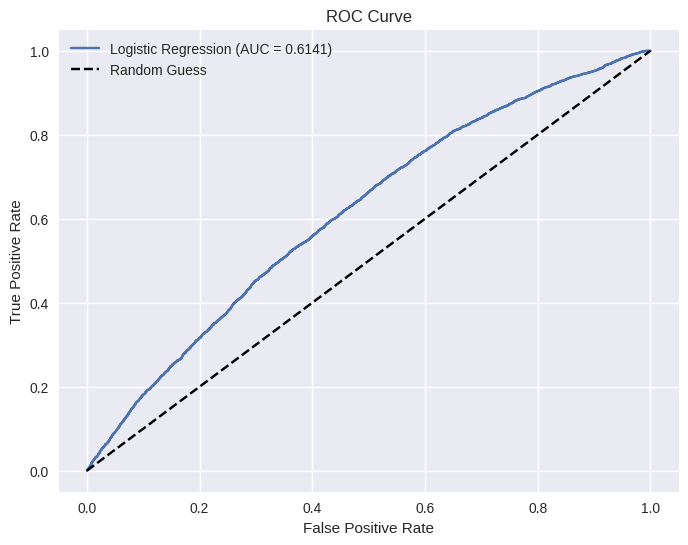

In [26]:
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities

# Calculate ROC curve values: FPR, TPR, and threshold values
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# Calculate AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_proba)
print("AUC-ROC Score:", auc_score)
# Calculate F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")  # Diagonal line for random guess
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Model Tuning

In [27]:
def log_reg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)
    model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]


    matrix = confusion_matrix(y_test, y_pred)
    accuracyScore = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = TP * 5.5 + (FP + TP) * -1

    return accuracyScore, auc_score, f1, profit

### Forward Selection

In [28]:
X = train_data_standardized.drop(columns=['IS_BOUND'])
y = train_data_standardized['IS_BOUND']
selected_features = []
remaining_features = X.columns.tolist()
best_auc = 0.5

while remaining_features:
    best_feature = None
    for feature in remaining_features:
        # Create a model with the current selected features plus the new candidate
        model = LogisticRegression()
        current_features = selected_features + [feature]

        # Evaluate model's precision using cross-validation
        accuracyScore, auc_score, f1, profit = log_reg(X[current_features], y)

        # Check if this precision is the best we've seen
        if auc_score > best_auc:
            best_auc = auc_score
            best_feature = feature

    if best_feature:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        print(f"Added feature: {best_feature} with auc: {auc_score}")
    else:
        break  # No more features improve precision

print("Selected features:", selected_features)

Added feature: MULTI_PRODUCT_No with auc: 0.5007204562436821
Added feature: Year_Birth_Decade_1980 with auc: 0.565485164079701
Added feature: VEHICLEYEAR with auc: 0.5894716633288857
Added feature: Year_Birth_Decade_1990 with auc: 0.5966262146892269
Added feature: Year_Birth_Decade_1970 with auc: 0.6023831166029755
Added feature: YEARS_LICENSED with auc: 0.6040459581463142
Added feature: OCCUPATION_Not Known with auc: 0.6091909216464317
Added feature: Year_Birth_Decade_9990 with auc: 0.6103825491402517
Added feature: Year_Birth_Decade_1940 with auc: 0.6112071434106816
Added feature: OCCUPATION_Office/Stores with auc: 0.6118204300048083
Added feature: MULTI_PRODUCT_Separated with auc: 0.612330605757327
Added feature: VEHICLEUSE_Pleasure with auc: 0.6128239756196465
Added feature: Year_Birth_Decade_1930 with auc: 0.6132490876027998
Added feature: CONVICTION_COUNT_CRIMINAL_3YRS with auc: 0.6137072763740913
Added feature: VEHICLEUSE_Farm Pleasure with auc: 0.6140950672971757
Added feature:

### Interaction Terms

In [29]:
X_interact = train_data_standardized[selected_features]
y = train_data_standardized['IS_BOUND']
highest_auc = 0.6141
for i in X_interact.columns:
    for j in X_interact.columns:
        joint_feature_name = f'{i}_{j}'
        X_temp = X_interact.copy()  # Work on a copy of the best feature set
        X_temp[joint_feature_name] = X_interact[i] * X_interact[j]  # Create the joint feature
        X_temp.drop(columns=[i, j], inplace=True)  # Remove the original features
        accuracyScore, auc_score, f1, profit = log_reg(X_temp, y)

        # If the auc improves, keep the joint feature
        if auc_score > highest_auc:
            highest_auc = auc_score
            X_interact[joint_feature_name] = X_temp[i] * X_temp[j]
            print(f"New highest AUC with {joint_feature_name}: {highest_auc}")
        else:
            print(f"No improvement with {joint_feature_name}, skipping.")
            X_temp.drop(columns=[joint_feature_name], inplace=True)  # Remove the joint feature

log_reg(X_interact, Y)

KeyError: 'MULTI_PRODUCT_No'

### Threshold

Accuracy: 0.5615369516144862
Confusion Matrix:
 [[8695 7301]
 [1634 2748]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.54      0.66     15996
         1.0       0.27      0.63      0.38      4382

    accuracy                           0.56     20378
   macro avg       0.56      0.59      0.52     20378
weighted avg       0.72      0.56      0.60     20378



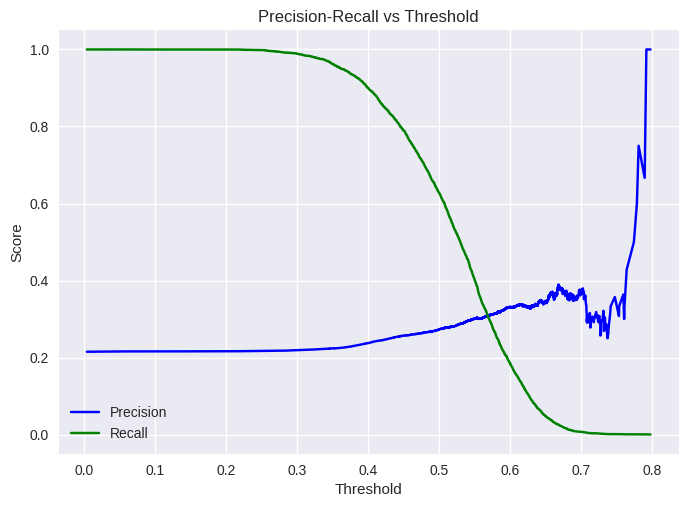

In [30]:
X = X_interact
y = train_data_standardized['IS_BOUND']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=64)

model = LogisticRegression(class_weight="balanced", random_state=89, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test) # Prediction

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

y_proba = model.predict_proba(X_test)[:, 1] # Predicted Probabilities


precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend(loc='best')
plt.show()

In [31]:
# Profit for true positives(TP): +5.5
# Cost for predicting a positive(1): -1


y_pred_prob = model.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.4, 0.5, 0.01)  # Adjust granularity if needed

#Evaluate performance at each threshold
for threshold in thresholds:
    # Predict class labels based on the threshold
    y_pred_custom = (y_pred_prob >= threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)
    f1 = f1_score(y_test, y_pred_custom)
    auc = roc_auc_score(y_test, y_pred_custom)  # AUC remains the same, independent of threshold

    matrix = confusion_matrix(y_test, y_pred_custom)
    TN, FP = matrix[0]
    FN, TP = matrix[1]
    profit = TP * 5.5 + (FP + TP) * -1
    # Print or store the metrics for each threshold
    print(f"Threshold: {threshold:.2f}")
    print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, AUC-ROC: {auc:.3f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
    print(f"Total Profit: {profit}")
    print("-" * 30)

Threshold: 0.40
Precision: 0.238, Recall: 0.900, F1-Score: 0.376, AUC-ROC: 0.554
Confusion Matrix:
 [[ 3337 12659]
 [  439  3943]]
Total Profit: 5084.5
------------------------------
Threshold: 0.41
Precision: 0.242, Recall: 0.881, F1-Score: 0.380, AUC-ROC: 0.562
Confusion Matrix:
 [[ 3895 12101]
 [  521  3861]]
Total Profit: 5273.5
------------------------------
Threshold: 0.42
Precision: 0.245, Recall: 0.856, F1-Score: 0.381, AUC-ROC: 0.567
Confusion Matrix:
 [[ 4442 11554]
 [  629  3753]]
Total Profit: 5334.5
------------------------------
Threshold: 0.43
Precision: 0.249, Recall: 0.835, F1-Score: 0.384, AUC-ROC: 0.573
Confusion Matrix:
 [[ 4986 11010]
 [  725  3657]]
Total Profit: 5446.5
------------------------------
Threshold: 0.44
Precision: 0.254, Recall: 0.814, F1-Score: 0.387, AUC-ROC: 0.579
Confusion Matrix:
 [[ 5509 10487]
 [  813  3569]]
Total Profit: 5573.5
------------------------------
Threshold: 0.45
Precision: 0.257, Recall: 0.789, F1-Score: 0.388, AUC-ROC: 0.582
Conf

# Modelling Method 2 - Random Forests

In [32]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

tree_insurance = DecisionTreeClassifier(min_samples_leaf=10, max_depth=6)
tree_insurance.fit(X, y)
y_pred = tree_insurance.predict(X)

tree_insurance.score(X, y)

0.7812837373638237

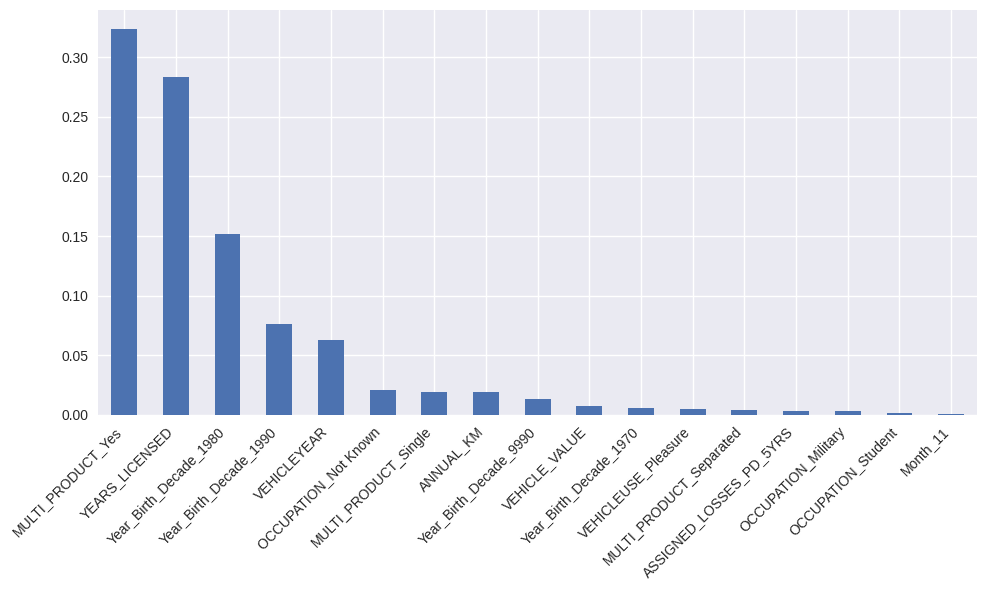

In [33]:
def plot_feature_importances(model, feature_names):
   # Get feature importances and names
   importances = model.feature_importances_

   # Get non-zero features only
   non_zero_idx = importances > 0
   importances = importances[non_zero_idx]
   if isinstance(feature_names, pd.Index):
       feature_names = feature_names[non_zero_idx]
   else:
       feature_names = [feature_names[i] for i in range(len(non_zero_idx)) if non_zero_idx[i]]

   # Sort them in descending order
   indices = np.argsort(importances)[::-1]

   # Create figure
   plt.figure(figsize=(10, 6))

   # Create bar plot
   plt.bar(range(len(importances)), importances[indices])

   # Add labels
   plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
   plt.xlabel('Features')
   plt.ylabel('Importance')
   plt.title('Feature Importances (Non-zero only)')

   # Adjust layout to prevent label cutoff
   plt.tight_layout()

   plt.show()

# Or the simpler pandas version:
importance_series = pd.Series(tree_insurance.feature_importances_, index=X.columns)
importance_series = importance_series[importance_series > 0]  # Keep only non-zero values
importance_series.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

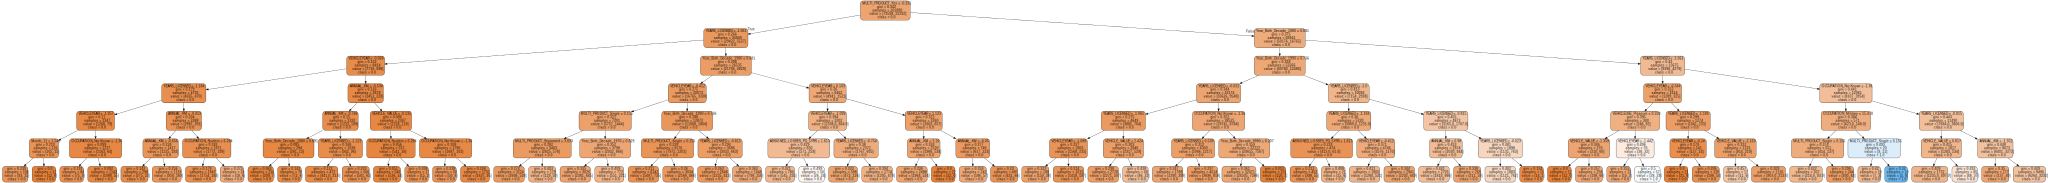

In [34]:
from graphviz import Source

class_names = [str(name) for name in tree_insurance.classes_]


tree_insurance_graph = export_graphviz(tree_insurance,
                                      out_file=None,
                                      feature_names=X.columns,
                                      class_names=class_names,
                                      filled=True,
                                      rounded=True,
                                      special_characters=True)

Source(tree_insurance_graph)

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, test_size=0.5, random_state=42)

In [36]:
tree_insurance_tt = DecisionTreeClassifier(min_samples_leaf=5, max_depth=6)
tree_insurance_tt.fit(X_train, y_train)
y_pred = tree_insurance_tt.predict(X_test)

tree_insurance_tt.score(X_train, y_train), tree_insurance_tt.score(X_test, y_test)

(0.7825890666404947, 0.7795465698302091)

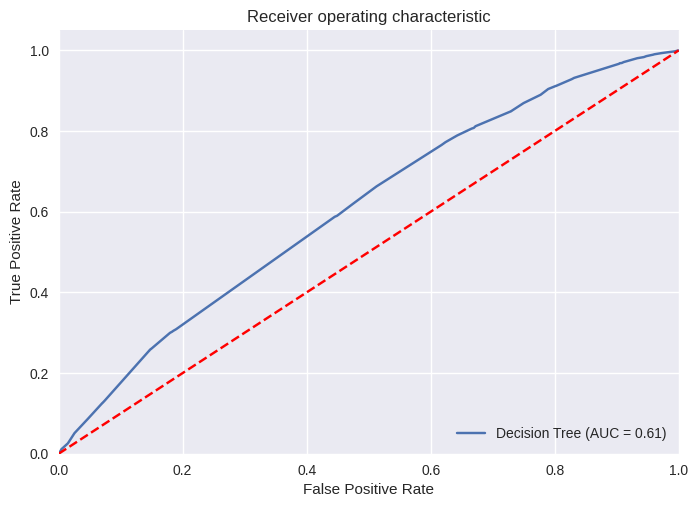

In [37]:
# prompt: plot the ROC curve for the decision tree model

y_pred_proba = tree_insurance_tt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     39736
         1.0       0.33      0.00      0.00     11209

    accuracy                           0.78     50945
   macro avg       0.55      0.50      0.44     50945
weighted avg       0.68      0.78      0.68     50945



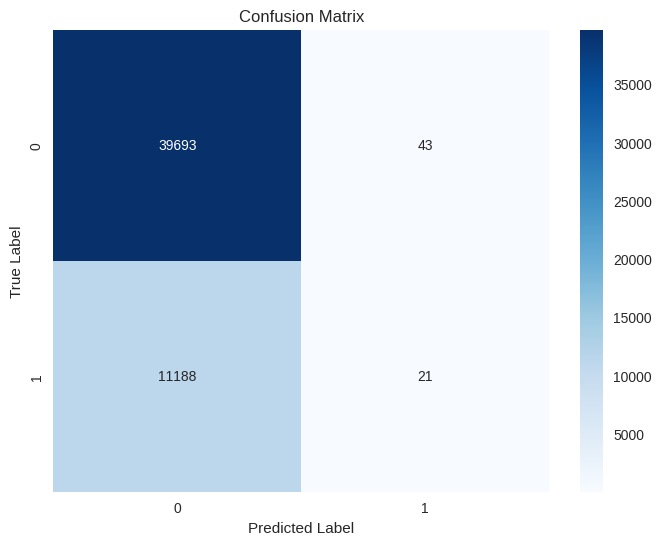

In [39]:
cm = confusion_matrix(y_test, y_pred)

# Plot it using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

insurance_bag = RandomForestRegressor(max_features=13, random_state=42)
insurance_bag.fit(X_train, y_train)

y_pred = insurance_bag.predict(X_test)

mean_squared_error(y_test, y_pred)

0.18920582723830637

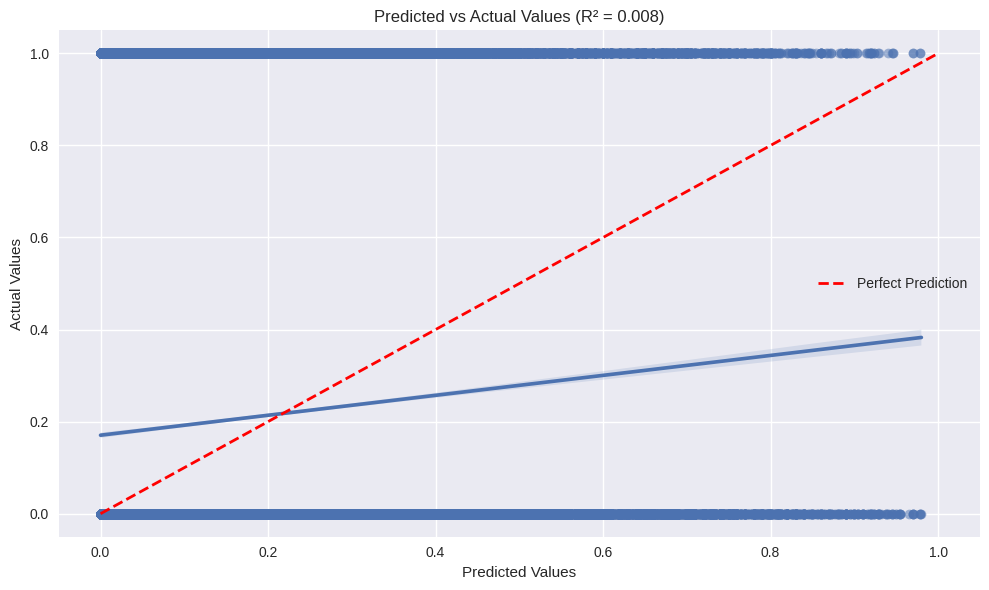

In [41]:
def plot_prediction_analysis(y_test, y_pred):
    # Calculate R-squared
    r2 = np.corrcoef(y_test, y_pred)[0,1]**2

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create regression plot
    sns.regplot(x=y_pred, y=y_test, scatter_kws={'alpha':0.5})

    # Add perfect prediction line
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')

    # Add labels and title
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.3f})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Use it like this:
plot_prediction_analysis(y_test, y_pred)

In [42]:
insurance_rf = RandomForestRegressor(max_features=6, random_state=42, n_estimators=100)
insurance_rf.fit(X_train, y_train)

y_pred = insurance_rf.predict(X_test)

mean_squared_error(y_test, y_pred)

0.18988469438237235

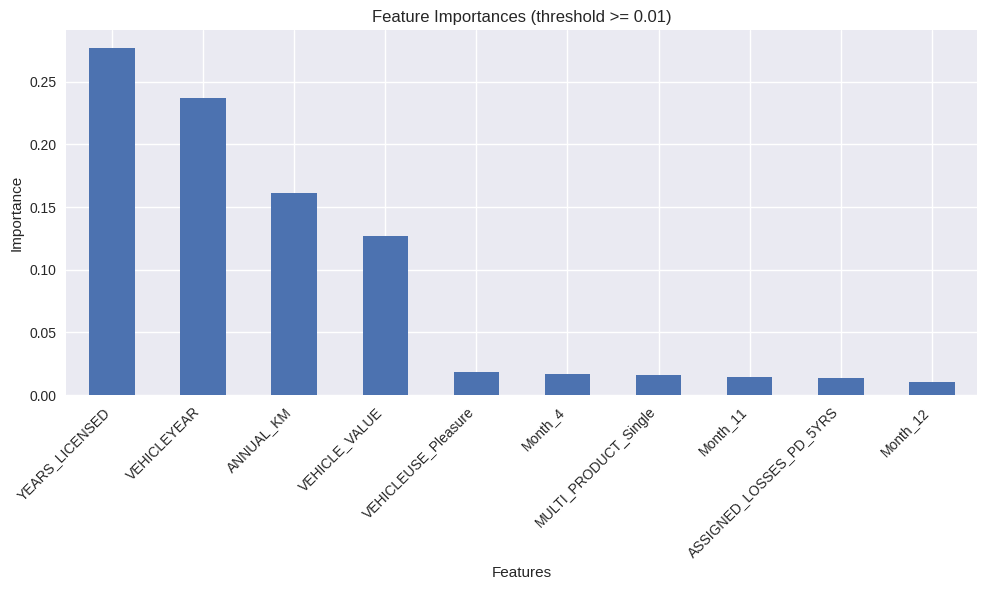


Feature Importances:
YEARS_LICENSED: 0.2772
VEHICLEYEAR: 0.2373
ANNUAL_KM: 0.1609
VEHICLE_VALUE: 0.1267
VEHICLEUSE_Pleasure: 0.0187
Month_4: 0.0168
MULTI_PRODUCT_Single: 0.0159
Month_11: 0.0142
ASSIGNED_LOSSES_PD_5YRS: 0.0134
Month_12: 0.0104


In [43]:
def plot_feature_importances(model, feature_names, x_tick_rotation=45, threshold=0.01):
    # Get feature importances
    importances = pd.Series(model.feature_importances_, index=feature_names)

    # Filter features above threshold
    importances = importances[importances >= threshold]

    # Sort in descending order
    importances = importances.sort_values(ascending=False)

    # Create figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    importances.plot(kind='bar')

    # Add labels and title
    plt.title(f'Feature Importances (threshold >= {threshold})')
    plt.xlabel('Features')
    plt.ylabel('Importance')

    # Rotate x-axis labels
    plt.xticks(rotation=x_tick_rotation, ha='right')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    plt.show()

    # Print sorted importances
    print("\nFeature Importances:")
    for name, importance in importances.items():
        print(f"{name}: {importance:.4f}")

# Use it like this:
plot_feature_importances(insurance_rf, X.columns, x_tick_rotation=45, threshold=0.01)

In [44]:
# Get important features (e.g., those with importance > threshold)
threshold = 0.01  # adjust this based on your needs
important_features = pd.Series(insurance_rf.feature_importances_, index=X.columns)
important_features = important_features[important_features > threshold].index

# Create new dataset with only important features
X_important = X[important_features]

# Train new model with important features only
model_important = DecisionTreeClassifier(random_state=42)  # or your chosen model
model_important.fit(X_important, y)

DecisionTreeClassifier(random_state=42)

In [45]:
from sklearn.model_selection import cross_val_score

# Original model performance
scores_original = cross_val_score(insurance_rf, X, y, cv=5)

# New model performance with important features only
scores_important = cross_val_score(model_important, X_important, y, cv=5)

print("Original model CV scores:", scores_original.mean(), "±", scores_original.std())
print("Important features model CV scores:", scores_important.mean(), "±", scores_important.std())

Original model CV scores: -0.13116473688669847 ± 0.009568083985473092
Important features model CV scores: 0.696594366473648 ± 0.008980160217079248


In [46]:
if len(important_features) >= 2:
    top_2_features = important_features[:2]
    X_important[f'{top_2_features[0]}_x_{top_2_features[1]}'] = (
        X_important[top_2_features[0]] * X_important[top_2_features[1]]
    )

<ipython-input-46-1e142eda9133>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_important[f'{top_2_features[0]}_x_{top_2_features[1]}'] = (


In [58]:
# prompt: fit a random forest model with the important features and calculate accuracy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_important and y are already defined from the previous code

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7425655118264796


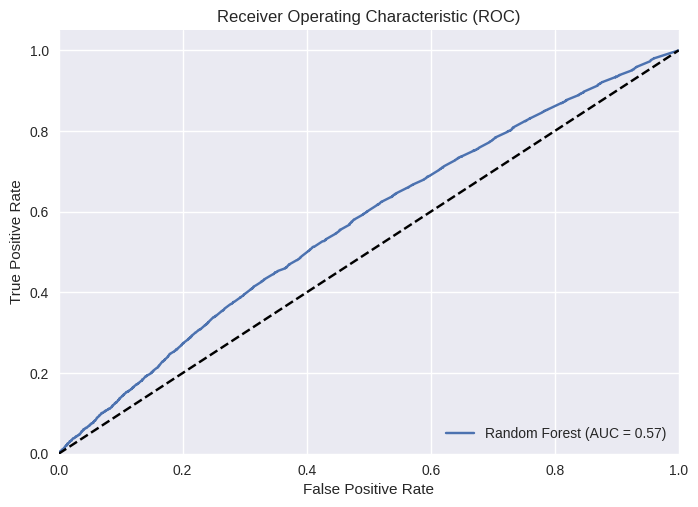

In [59]:
# prompt: plot ROC curve of the random forest model

# Assuming you have your Random Forest model trained as 'rf_model'
# and your X_test and y_test are defined

# Get predicted probabilities for the positive class
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [60]:
# prompt: use RandomizedSearchCV for hyperparamter tuning

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Use the best model for prediction
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
Best score: 0.7818848759505468
Accuracy: 0.7784866031995289


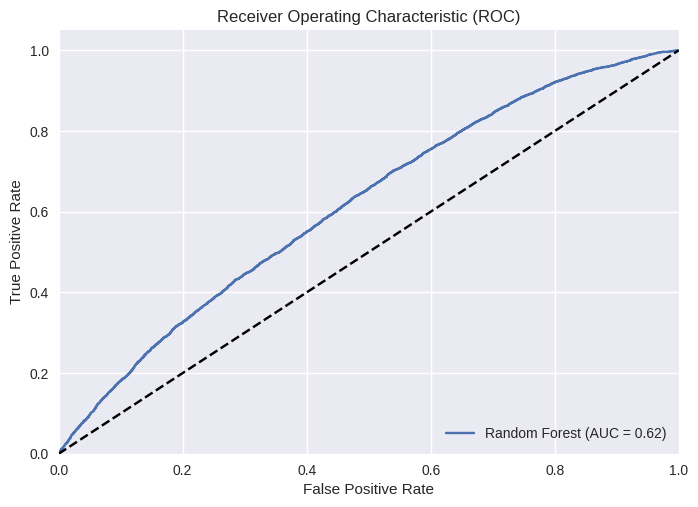

In [64]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class (1)
y_pred_probb = best_rf_model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probb)

# Calculate the area under the ROC curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred_probb)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [63]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)

# Set a threshold (e.g., top 20 features or a certain importance value)
threshold = 0.01
important_features = feature_importances[feature_importances > threshold].index

# Use only important features for future modeling
X_important = X[important_features]
print(important_features)

Index(['VEHICLEYEAR', 'YEARS_LICENSED', 'VEHICLEUSE_Pleasure', 'VEHICLE_VALUE',
       'MULTI_PRODUCT_Single', 'ASSIGNED_LOSSES_PD_5YRS', 'Month_12',
       'Month_11', 'ANNUAL_KM', 'Month_4'],
      dtype='object')


Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best score: 0.7818603413414829
Accuracy: 0.7784866031995289


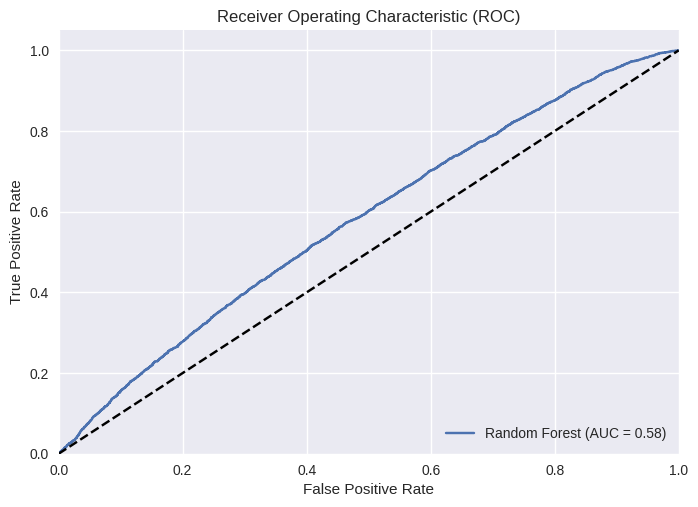

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Split data with important features into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)


# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Initialize a new RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5, min_samples_leaf=1, max_depth=10)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate ROC curve and AUC
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
